In [15]:
%pip install mne xgboost tensorflow scikit-learn pandas numpy matplotlib scipy tqdm


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                           classification_report, cohen_kappa_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (LSTM, GRU, SimpleRNN, Dense, Dropout, 
                                    Input, MultiHeadAttention, LayerNormalization,
                                    TimeDistributed, Flatten, Bidirectional)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import warnings
from scipy import signal
warnings.filterwarnings('ignore')

In [17]:
def load_emotion_data(data_dir):                                                        # Emotion icin veri setini yukluyoruz.
    file_pairs = []
    
    for f in os.listdir(data_dir):                                                      # Dosya eslestirme islemi yapiyoruz.
        if f.endswith('.set'):
            events_file = f.replace('_eeg.set', '_events.tsv')                          # Set dosyasi ham sinyalleri tutar, tsv dosyasi eventleri tutar.
            events_path = os.path.join(data_dir, events_file)
            if os.path.exists(events_path):
                file_pairs.append((
                    os.path.join(data_dir, f),
                    events_path
                ))
            else:
                print(f"Event dosyası bulunamadı: {events_path}")
    
    print(f"Bulunan EEG-Event çiftleri: {len(file_pairs)}")
    for pair in file_pairs:
        print(f"  {pair[0]} - {pair[1]}")
    return file_pairs


In [18]:
from scipy.signal import find_peaks, welch
from scipy.stats import entropy, kurtosis, skew, iqr

def bandpower(psd, freqs, fmin, fmax):
    idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
    return np.sum(psd[idx_band])

def extract_emotion_features(data, sfreq, n_fft_comp=5):
    feature_list = []
    count = 0
    
    # Zaman serisinde ozellik cikarimi yapiyorum. Buradaki ozniteliklerin cogunu TSFEL: Time Series Feature Extraction Library makalesinden aldim.

    for epoch in data:
        feats = []
        for ch_signal in epoch:
            t = np.arange(len(ch_signal))
            abs_energy = np.sum(ch_signal**2)                                                           # Sinyalin toplam enerjisi, guc olcusu
            area_curve = np.trapz(ch_signal)                                                            # Egri alti alan, sinyalin integraline benzer toplam degeri
            
            autocorr = np.corrcoef(ch_signal[:-1], ch_signal[1:])[0, 1] if np.std(ch_signal) > 0 else 0 # Sinyalin kendisiyle bir gecikmeyle olan korelasyonu
            
            avg_power = np.mean(ch_signal**2)                                                           # Ortalama guc
            centroid = np.sum(t * np.abs(ch_signal)) / (np.sum(np.abs(ch_signal)) + 1e-12)              # Sinyal agirlik merkezi
            
            hist, _ = np.histogram(ch_signal, bins=10, density=True)
            hist_entropy = entropy(hist + 1e-12)                                                        # Sinyal genlik dagiliminin duzensizligi
            
            freqs, psd = welch(ch_signal, sfreq, nperseg=min(256, len(ch_signal)))
            psd /= np.sum(psd) + 1e-12                                                                  # Frekanslara gore enerji dagilimi
            
            fund_freq = freqs[np.argmax(psd)] if len(psd) > 0 else 0                                    # En yuksek guce sahip frekans bileşeni
            
            hist_vals, hist_bins = np.histogram(ch_signal, bins=10)
            hist_mode = hist_bins[np.argmax(hist_vals)]                                                 # En cok gorulen genlik degeri
            
            human_energy = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])                                  # Insan EEG bandindaki enerji
            iqr_val = iqr(ch_signal)                                                                    # Sinyalin orta %50'sinin yayilimi
            kurt_val = kurtosis(ch_signal)                                                              # Carpiklik, uc deger yogunlugu
            
            max_val = np.max(ch_signal)                                                                 # Maksimum deger
            max_psd = np.max(psd)                                                                       # Maksimum guc
            max_freq = freqs[-1]                                                                        # En yuksek olculebilir frekans
            
            mean_val = np.mean(ch_signal)                                                               # Ortalama deger
            mad = np.mean(np.abs(ch_signal - mean_val))                                                 # Ortalama mutlak sapma
            mean_abs_diff = np.mean(np.abs(np.diff(ch_signal)))                                         # Komşu ornekler arasindaki ortalama mutlak fark
            mean_diff = np.mean(np.diff(ch_signal))                                                     # Komşu ornekler arasindaki ortalama fark
            
            med_val = np.median(ch_signal)                                                              # Medyan deger
            med_abs_dev = np.median(np.abs(ch_signal - med_val))                                        # Medyan mutlak sapma
            med_abs_diff = np.median(np.abs(np.diff(ch_signal)))                                        # Medyan komşu mutlak farki
            med_diff = np.median(np.diff(ch_signal))                                                    # Medyan komşu farki
            cumulative_power = np.cumsum(psd)
            med_freq = freqs[np.argmax(cumulative_power >= 0.5)] if len(psd) > 0 else 0                 # Medyan frekans
            
            min_val = np.min(ch_signal)                                                                 # Minimum deger
            
            diff_signal = np.diff(ch_signal)
            sign_changes = np.diff(np.sign(diff_signal))
            neg_turning = np.sum(sign_changes > 0)                                                      # Negatif egimden pozitif egime geciş sayisi
            pos_turning = np.sum(sign_changes < 0)                                                      # Pozitif egimden negatif egime geciş sayisi
            peaks, _ = find_peaks(ch_signal)
            n_peaks = len(peaks)                                                                        # Tepe sayisi
            peak_dist = np.mean(np.diff(peaks)) if n_peaks > 1 else 0                                   # Tepeler arasi ortalama mesafe
            
            if len(psd) > 0:
                peak_psd = np.max(psd)
                mask = psd >= (peak_psd / 2)
                try:
                    power_bandwidth = freqs[mask][-1] - freqs[mask][0]                                  # Gucun %50'sinden fazlasini iceren frekans araligi
                except:
                    power_bandwidth = 0
            else:
                power_bandwidth = 0
                
            rms = np.sqrt(avg_power)                                                                    
            signal_dist = np.sum(np.abs(ch_signal))                                                     # Mutlak genlik toplami
            skew_val = skew(ch_signal)                                                                  # Simetri olcusu
            slope = np.polyfit(t, ch_signal, 1)[0]                                                      # Lineer egim, trend
            
            spec_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-12)                                 # Spektral agirlik merkezi
            spec_decrease = np.sum((psd[1:] - psd[0]) / np.arange(1, len(psd))) / (np.sum(psd[1:]) + 1e-12) if len(psd) > 1 else 0   # Yuksek frekanslardaki guc kaybi
            spec_ent = entropy(psd + 1e-12)                                                             # Spektral entropi
            spec_kurt = kurtosis(psd)                                                                   # Spektral carpiklik
            diff_psd = np.diff(psd)
            psd_sign_changes = np.diff(np.sign(diff_psd))
            spec_pos_turning = np.sum(psd_sign_changes < 0)                                             # Spektral donuş noktasi sayisi
            spec_roll_off = freqs[np.argmax(cumulative_power >= 0.85)] if len(psd) > 0 else 0           # Enerjinin %85'ine ulaşilan frekans
            spec_roll_on = freqs[np.argmax(cumulative_power >= 0.05)] if len(psd) > 0 else 0            # Enerjinin %5'ine ulaşilan frekans
            spec_skew = skew(psd)                                                                       # Spektral skewness
            spec_slope = np.polyfit(freqs, psd, 1)[0] if len(psd) > 1 else 0                            # Spektral egim
            spec_spread = np.sqrt(np.sum(psd * (freqs - spec_centroid)**2) / (np.sum(psd) + 1e-12))     # Spektral yayilma
            
            std = np.std(ch_signal)                                                                     # Standart sapma
            sum_abs_diff = np.sum(np.abs(np.diff(ch_signal)))                                           # Ornekler arasi toplam fark
            var = np.var(ch_signal)                                                                     # Varyans
            
            zero_crossings = np.sum(np.diff(np.sign(ch_signal)) != 0)
            zcr = zero_crossings / len(ch_signal)                                                       # Sinyalin kac kez sifiri gectigi

            bp_delta = bandpower(psd, freqs, 0.5, 4)                                                    # Bant güçleri (delta: 0.5–4Hz, theta: 4–8Hz, alpha: 8–13Hz, beta: 13–30Hz, gamma: 30–40Hz)
            bp_theta = bandpower(psd, freqs, 4, 8)
            bp_alpha = bandpower(psd, freqs, 8, 13)
            bp_beta  = bandpower(psd, freqs, 13, 30)
            bp_gamma = bandpower(psd, freqs, 30, 40)
            
            fft_vals = np.fft.rfft(ch_signal)                                                           # FFT bileşenleri (en büyük n_fft_comp genlik)
            fft_power = np.abs(fft_vals)
            top_fft_indices = np.argsort(fft_power)[-n_fft_comp:][::-1]
            top_fft_components = fft_power[top_fft_indices]

            features = [
                abs_energy, area_curve, autocorr, avg_power, centroid, hist_entropy,
                fund_freq, hist_mode, human_energy, iqr_val, kurt_val, max_val,
                bp_delta, bp_theta, bp_alpha, bp_beta, bp_gamma, *top_fft_components,
                max_psd, max_freq, mean_val, mad, mean_abs_diff, mean_diff, med_val,
                med_abs_dev, med_abs_diff, med_diff, med_freq, min_val, neg_turning,
                n_peaks, peak_dist, pos_turning, power_bandwidth, rms, signal_dist,
                skew_val, slope, spec_centroid, spec_decrease, spec_ent,
                spec_kurt, spec_pos_turning, spec_roll_off, spec_roll_on, spec_skew,
                spec_slope, spec_spread, std, sum_abs_diff, var, zcr
            ]
            
            feats.extend(features)
            
        feature_list.append(feats)
        count += 1
        
    print(f"Özellik çıkarımı için toplam {count} epoch işlendi.")
    return np.array(feature_list)

In [19]:
"""label_mapping = {
    'ibeg': 0, 'iend': 1, 'rsrt': 2, 'fixl': 3,
    'quiz': 4, 'qdon': 5, 'base': 6, 'bend': 7, 'trno': 8,
    'fixL': 9, 'stm': 10, 'clic': 11, 'vlnc': 12, 'arsl': 13,
    'dmns': 14, 'lkng': 15, 'fmrt': 16, 'relv': 17, 'cate': 18,
    'IBEG': 19, 'IEND': 20, 'puse': 21, 'boundary': 22, 'stop': 23,
    'baseline': 24,'baseend': 25,'trialno': 26,'fixation loop': 27,
    'neutral_1_1': 28,'valence': 29,'arousal': 30,'dominance': 31,'liking': 32,
    'familiarity': 33,'relevance': 34,'3_2': 35,'click': 36,
    'impedances begin': 37,'emotion_categ': 38,'impedances end': 39,'stop event': 40
}"""
label_mapping = {                                                                               # Bazilari digerlerinin kucuk harfle yazilmis hali, onlari birlestirdim.
    'ibeg': 0, 'iend': 1, 'rsrt': 2, 'fixl': 3,
    'quiz': 4, 'qdon': 5, 'base': 6, 'bend': 7, 'trno': 8,
    'fixL': 9, 'stm': 10, 'clic': 11, 'vlnc': 12, 'arsl': 13,
    'dmns': 14, 'lkng': 15, 'fmrt': 16, 'relv': 17, 'cate': 18,
    'IBEG': 0, 'IEND': 1, 'puse': 19, 'boundary': 20, 'stop': 21,
    'baseline': 22,'baseend': 23,'trialno': 24,'fixation loop': 25,
    'neutral_1_1': 26,'valence': 27,'arousal': 13,'dominance': 14,'liking': 15,
    'familiarity': 16,'relevance': 17,'3_2': 28,'click': 29,
    'impedances begin': 30,'emotion_categ': 31,'impedances end': 32,'stop event': 33
}

def create_sequences(data, labels, seq_length=10):                                                          # Zaman serisi verileri olusturuyorum.
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(labels[i+seq_length-1])
    return np.array(X), np.array(y)

def create_emotion_dataset(file_pairs, epoch_duration=2.0, seq_length=10):
    all_sequences = []
    all_labels = []
    
    for eeg_file, event_file in tqdm(file_pairs, desc="Dosyalar işleniyor"):
        try:
            raw = mne.io.read_raw_eeglab(eeg_file, preload=True, verbose=False)                             # EEG verisini yukluyorum.
            events_df = pd.read_csv(event_file, sep='\t')                                                   # Olay dosyasini okuyorum.
            
            events = []
            for _, row in events_df.iterrows():                                                             # Her satiri okuyorum ve eventleri elde ediyorum.                                    
                sample = int(row['onset'] * raw.info['sfreq'] / 1000)
                label_str = str(row['trial_type']).lower().strip()
                label = label_mapping.get(label_str, -1)
                if label >= 0:
                    events.append([sample, 0, label])
            
            if not events:
                continue
                
            events_array = np.array(events, dtype=np.int64)
            
            epochs = mne.Epochs(                                                                             # Epochlari olusturuyorum.
                raw, 
                events_array, 
                tmin=0.0, 
                tmax=epoch_duration,
                baseline=None,
                preload=True,
                reject_by_annotation=False,
                on_missing='warn',
                event_repeated='merge'
            )
            
            if len(epochs) == 0:
                continue
                
            data = epochs.get_data()                                                                          # Verileri ve etiketleri aliyorum.
            labels = epochs.events[:, -1]
    
            feats = extract_emotion_features(data, raw.info['sfreq'])                                         # Özellikleri cikariyorum.
            
            counts = pd.Series(labels).value_counts()                                                         # Nadir siniflari filtreliyorum cunku hata veriyordu.
            valid_classes = counts[counts > 10].index
            mask = np.isin(labels, valid_classes)
            feats_filtered = feats[mask]
            labels_filtered = labels[mask]
            
            if len(feats_filtered) >= seq_length:                                                             # Zaman serilerini olusturuyorum.
                sequences, seq_labels = create_sequences(feats_filtered, labels_filtered, seq_length)
                all_sequences.append(sequences)
                all_labels.append(seq_labels)
                
        except Exception as e:
            print(f"Hata: {str(e)}")
            continue
    
    if all_sequences:                                                                                          # Tüm dosyalar islenince tum zaman serisi verilerini ve etiketlerini birlestiriyorum.
        X = np.vstack(all_sequences)
        y = np.hstack(all_labels)
        print(f"\nToplam {len(X)} zaman serisi oluşturuldu")
        print(f"Seri boyutu: {X.shape[1]} zaman adımı, {X.shape[2]} özellik")
        print(f"Sınıf dağılımı: {pd.Series(y).value_counts()}")
        return X, y
    else:
        print("\nUYARI: Hiç veri işlenemedi!")
        return np.array([]), np.array([])

In [20]:
def evaluate_model(y_true, y_pred, name):                                       # Temel metrikleri hesapliyorum
    acc = accuracy_score(y_true, y_pred)                                        # Isabet
    f1 = f1_score(y_true, y_pred, average='macro')                              # f1 skoru
    kappa = cohen_kappa_score(y_true, y_pred)                                   # Cohen Kappa skoru
    
    print(f"\n{name} Performans:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    
    unique_labels = np.unique(y_true)                                           # Sinif isimlerini aliyorum.
    unique_names = []
    for l in unique_labels:
        for key, val in label_mapping.items():
            if val == l:
                unique_names.append(key)
                break
    
    print("Sınıflandırma Raporu:")
    print(classification_report(y_true, y_pred, labels=unique_labels, target_names=unique_names))
        
    cm = confusion_matrix(y_true, y_pred)                                       # Confusion matrix gosteriyorum.
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{name} - Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(len(unique_names)), unique_names, rotation=45)
    plt.yticks(np.arange(len(unique_names)), unique_names)
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin')
    plt.tight_layout()
    plt.show()
        
    return acc, f1, kappa

def build_rnn_model(input_shape, rnn_type='lstm', units=128):
    model = Sequential()
    
    if rnn_type == 'lstm':                                                                                  # LSTM (uzun sureli bagimliliklari ogrenmede basarili)
        model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(LSTM(units)))
    elif rnn_type == 'gru':                                                                                 # GRU (daha hafif, daha hizli)
        model.add(Bidirectional(GRU(units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(GRU(units)))
    else:                                                                                                   # Basit RNN
        model.add(Bidirectional(SimpleRNN(units, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(SimpleRNN(units)))
    
    model.add(Dense(64, activation='relu'))                                                                 # Tam baglantili gizli katman, dropout katmani, cikis katmani tanimliyorum.
    model.add(Dropout(0.3))
    model.add(Dense(len(label_mapping), activation='softmax'))
    
    model.compile(
        loss='sparse_categorical_crossentropy',                                                             # Siniflandirma icin kayip fonksiyonu
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name, epochs=50):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)                   # Dogrulama kaybi duzelmezse durduruyorum.
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,                                                              
        validation_split=0.2,                                                                               # %20 validation boyutu
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = np.argmax(model.predict(X_test), axis=1)                                                       # Tahmin etme asamasi.
    metrics = evaluate_model(y_test, y_pred, model_name)                                                    # Performans metirklerini elde ediyorum.
    
    plt.figure(figsize=(12, 4))                                                                             # Egitim adimlarini gorsellestiriyorum.
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title(f'{model_name} - Doğruluk')
    plt.ylabel('Doğruluk')
    plt.xlabel('Epok')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title(f'{model_name} - Kayıp')
    plt.ylabel('Kayıp')
    plt.xlabel('Epok')
    plt.legend()
    plt.show()
    
    return model, metrics


def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=256, num_layers=2, dropout=0.2):                 # Transformer modelini tanimlamayla ilgili kismi ChatGPT'den aldim.
    inputs = Input(shape=input_shape)                                                                                       # Giris katmani                                                                                   
    x = inputs
    
    for _ in range(num_layers):
        attn_output = MultiHeadAttention(                                                                                   # Girdinin her zaman adiminin, diger tum adimlarla olan bagini ogrenmesini saglar.
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
        attn_output = Dropout(dropout)(attn_output)                                                                         # Overfitting'i azaltmak icin
        res = attn_output + x                                                                                               # Girdiyi cikisa ekler, bu aglarin daha kolay ogrenmesini saglar, gradyan kaybi sorununu azaltir.
        

        x = LayerNormalization(epsilon=1e-6)(res)                                                                           # Normalizasyon katmani  
        x = Dense(ff_dim, activation="relu")(x)                                                                             # Gizli katman
        x = Dropout(dropout)(x)                                                                                             # Dropout asiri ogrenmeyi azaltir.
        x = Dense(input_shape[-1])(x)                                                                                       # Giris boyutuna geri projeksiyon yapar.
        x = x + res
    
    x = Flatten()(x)                                                                                                        # Vektor haline getiriyorum.
    x = Dropout(dropout)(x)
    outputs = Dense(len(label_mapping), activation="softmax")(x)                                                            # Cikis katmani
    
    model = Model(inputs, outputs)                                                                                          # Modeli olusturuyorum.
    model.compile(
        loss="sparse_categorical_crossentropy",                                                                             # Siniflandirma icin kayip fonksiyonu
        optimizer=Adam(learning_rate=1e-3),
        metrics=["accuracy"]
    )
    return model

Bulunan EEG-Event çiftleri: 3
  ./EmotionData/Emotion_EDF_Training_Data\sub-mit096_task-Emotion_eeg.set - ./EmotionData/Emotion_EDF_Training_Data\sub-mit096_task-Emotion_events.tsv
  ./EmotionData/Emotion_EDF_Training_Data\sub-mit097_task-Emotion_eeg.set - ./EmotionData/Emotion_EDF_Training_Data\sub-mit097_task-Emotion_events.tsv
  ./EmotionData/Emotion_EDF_Training_Data\sub-mit104_task-Emotion_eeg.set - ./EmotionData/Emotion_EDF_Training_Data\sub-mit104_task-Emotion_events.tsv


Dosyalar işleniyor:   0%|          | 0/3 [00:00<?, ?it/s]

Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 501 original time points ...
0 bad epochs dropped


Dosyalar işleniyor:  33%|███▎      | 1/3 [01:11<02:23, 71.62s/it]

Özellik çıkarımı için toplam 141 epoch işlendi.
Not setting metadata
133 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 133 events and 501 original time points ...
0 bad epochs dropped


Dosyalar işleniyor:  67%|██████▋   | 2/3 [02:18<01:08, 68.70s/it]

Özellik çıkarımı için toplam 133 epoch işlendi.
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 501 original time points ...
0 bad epochs dropped


Dosyalar işleniyor: 100%|██████████| 3/3 [03:20<00:00, 66.80s/it]

Özellik çıkarımı için toplam 120 epoch işlendi.

Toplam 281 zaman serisi oluşturuldu
Seri boyutu: 10 zaman adımı, 7524 özellik
Sınıf dağılımı: 8     30
3     30
10    30
12    30
13    30
14    30
15    30
16    30
17    28
11    13
Name: count, dtype: int64
X shape: (281, 10, 7524) y shape: (281,)


Özellik seçimi sonrası boyut: (281, 10, 2500)
\RNN Model Eğitimi:
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.0523 - loss: 3.8889 - val_accuracy: 0.0500 - val_loss: 3.3667
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1088 - loss: 3.1271 - val_accuracy: 0.0250 - val_loss: 3.2282
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1045 - loss: 2.9305 - val_accuracy: 0.0500 - val_loss: 3.1150
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1092 - loss: 2.7486 - val_accuracy: 0.0750 - val_loss: 2.9349
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1888 - loss: 2.5662 - val_accuracy: 0.0750 - val_loss: 2.8477
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1948 - loss: 2.6377 - val_accuracy: 0.0500 - val_loss: 2.8553
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2238 - loss: 2.4724 - val_accuracy: 0.0750 - val_loss: 2.8386
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accurac

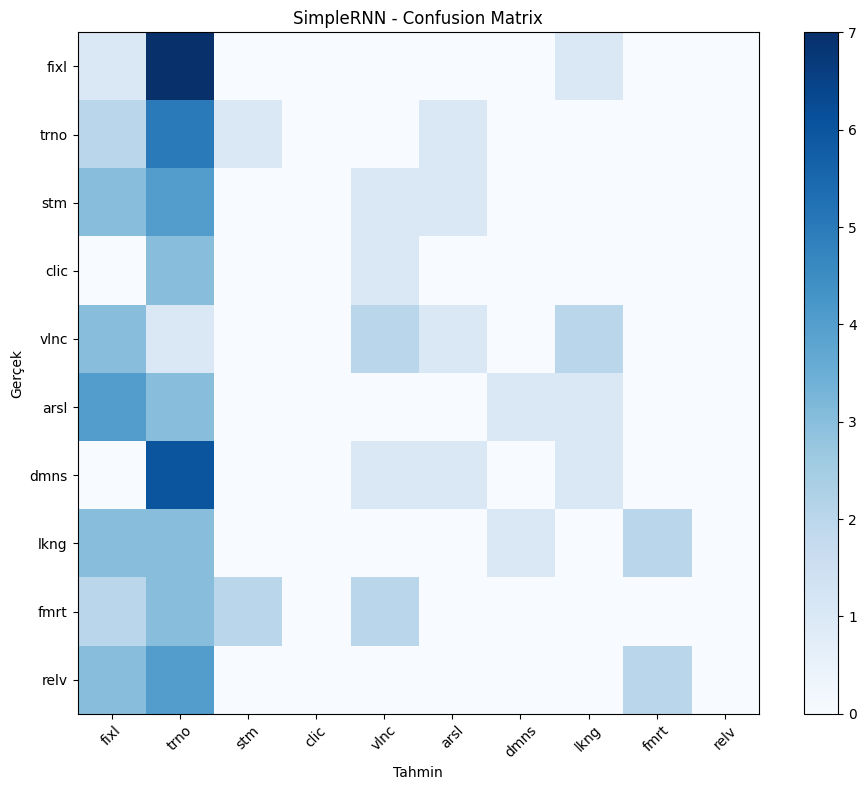

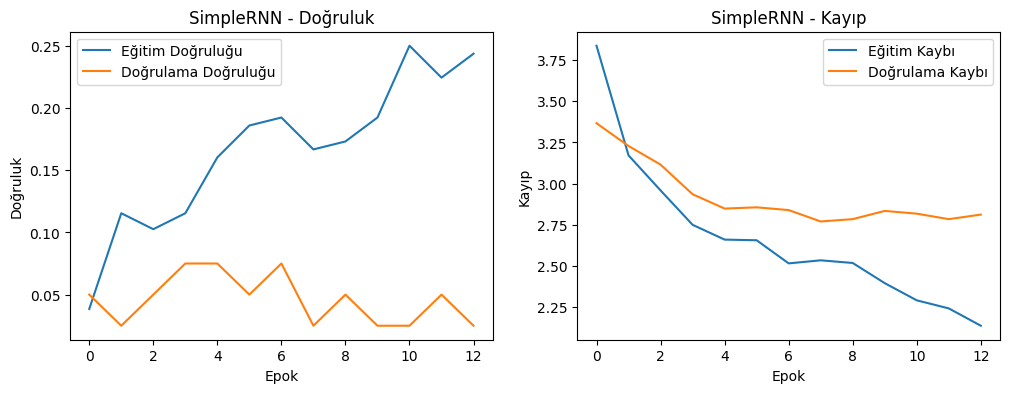


LSTM Model Eğitimi:
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.0924 - loss: 3.5250 - val_accuracy: 0.0500 - val_loss: 3.2444
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.0833 - loss: 3.1172 - val_accuracy: 0.0750 - val_loss: 3.0988
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1149 - loss: 2.9458 - val_accuracy: 0.0750 - val_loss: 3.0615
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1407 - loss: 2.8697 - val_accuracy: 0.0500 - val_loss: 3.0147
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1983 - loss: 2.6653 - val_accuracy: 0.0000e+00 - val_loss: 2.9535
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1675 - loss: 2.6686 - val_accuracy: 0.0500 - val_loss: 2.9046
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1452 - loss: 2.6288 - val_accuracy: 0.0250 - val_loss: 2.8252
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1814 - loss: 2.4888 - val_accuracy: 

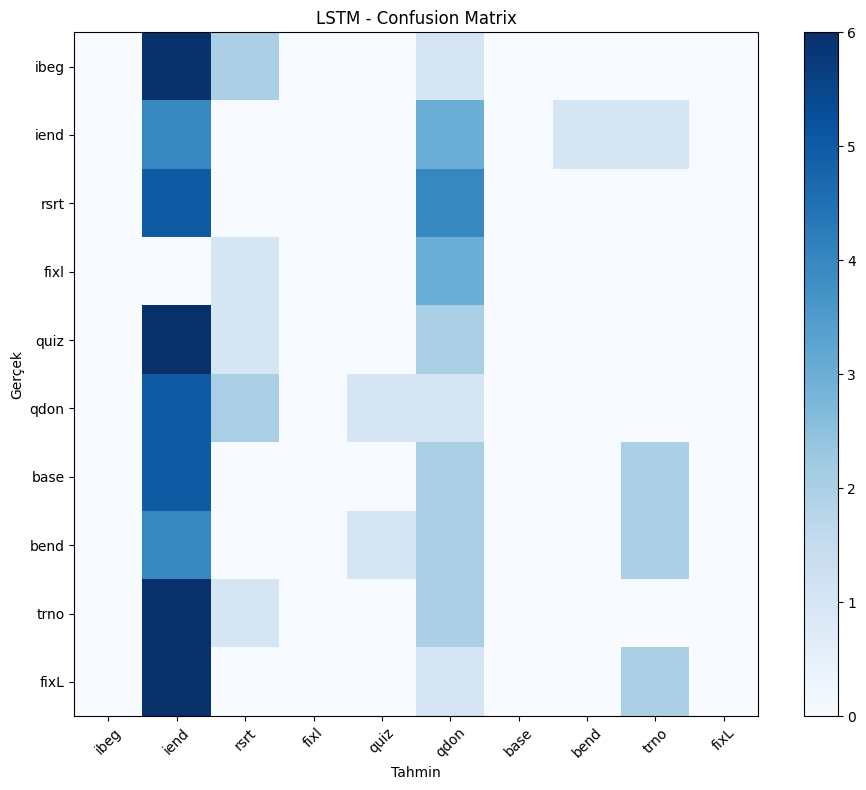

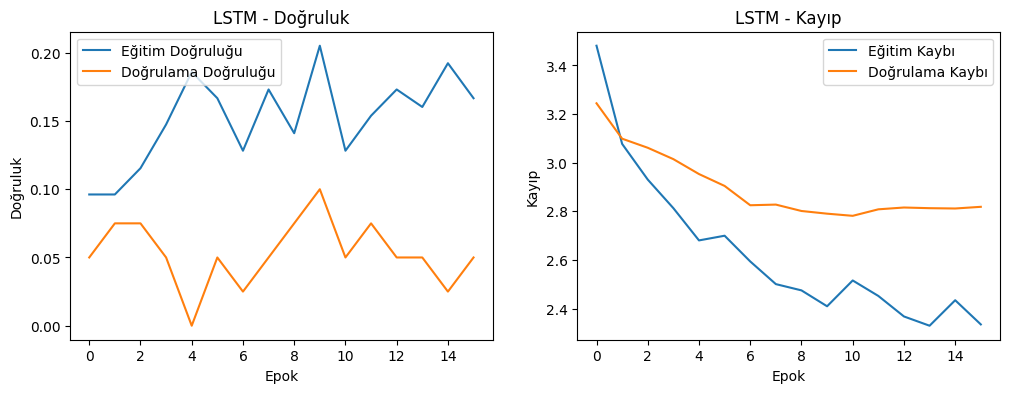


GRU Model Eğitimi:
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.0142 - loss: 3.8330 - val_accuracy: 0.1000 - val_loss: 3.2666
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1015 - loss: 3.1689 - val_accuracy: 0.0000e+00 - val_loss: 3.0885
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1633 - loss: 3.0470 - val_accuracy: 0.0000e+00 - val_loss: 3.0033
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1316 - loss: 2.9706 - val_accuracy: 0.0750 - val_loss: 2.9563
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1486 - loss: 2.8632 - val_accuracy: 0.1500 - val_loss: 2.8952
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1343 - loss: 2.7722 - val_accuracy: 0.0500 - val_loss: 2.9728
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2078 - loss: 2.6518 - val_accuracy: 0.0500 - val_loss: 2.9765
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.1393 - loss: 2.8005 - val_accurac

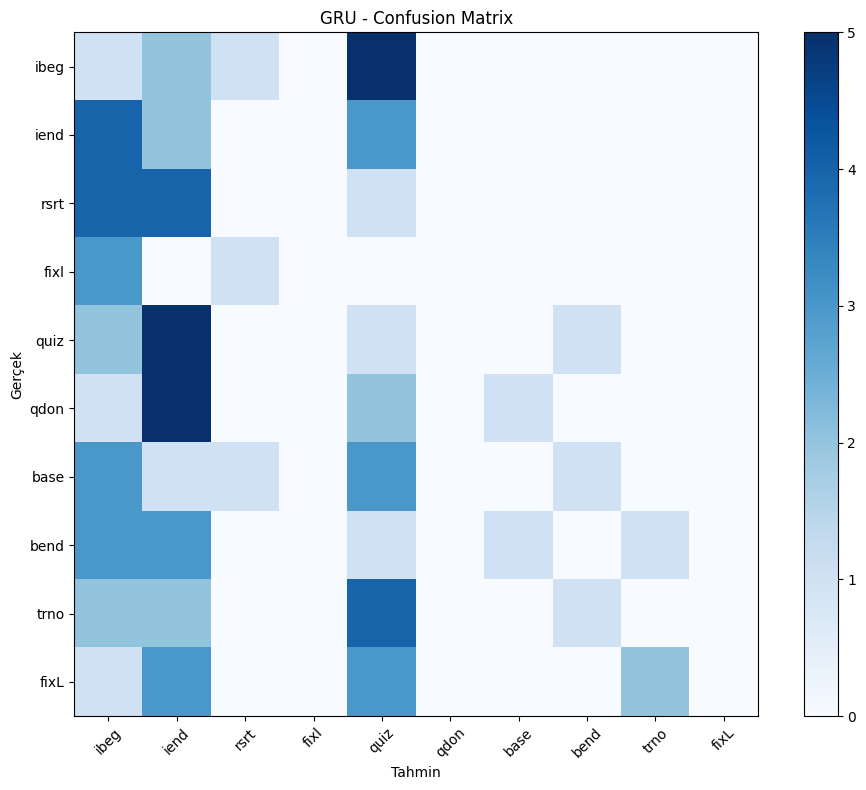

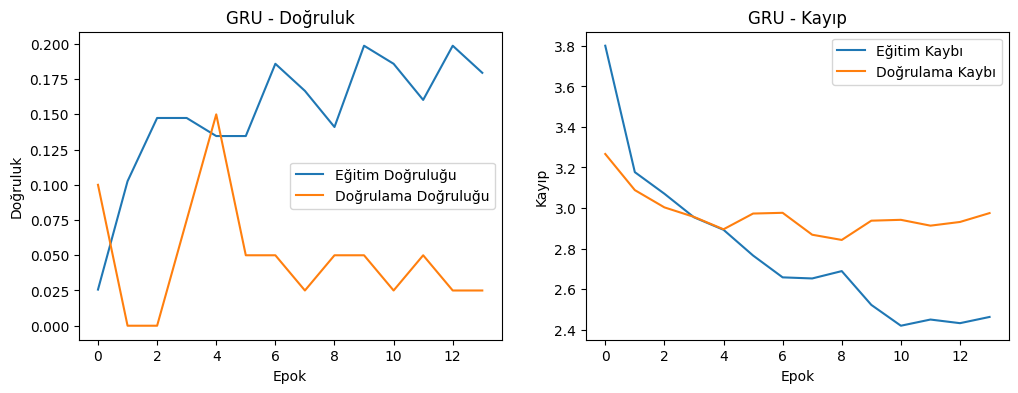


Transformer Model Eğitimi:
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.0609 - loss: 14.5702 - val_accuracy: 0.1250 - val_loss: 19.7228
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step - accuracy: 0.1075 - loss: 19.5655 - val_accuracy: 0.0500 - val_loss: 16.2300
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - accuracy: 0.1622 - loss: 10.6538 - val_accuracy: 0.1000 - val_loss: 17.0281
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - accuracy: 0.1956 - loss: 11.1913 - val_accuracy: 0.0500 - val_loss: 15.2674
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.2698 - loss: 7.7081 - val_accuracy: 0.0250 - val_loss: 11.6560
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.2639 - loss: 7.5033 - val_accuracy: 0.0750 - val_loss: 17.1052
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.3597 - loss: 5.6733 - val_accuracy: 0.0250 - val_loss: 15.1439
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.3384 - loss: 5.

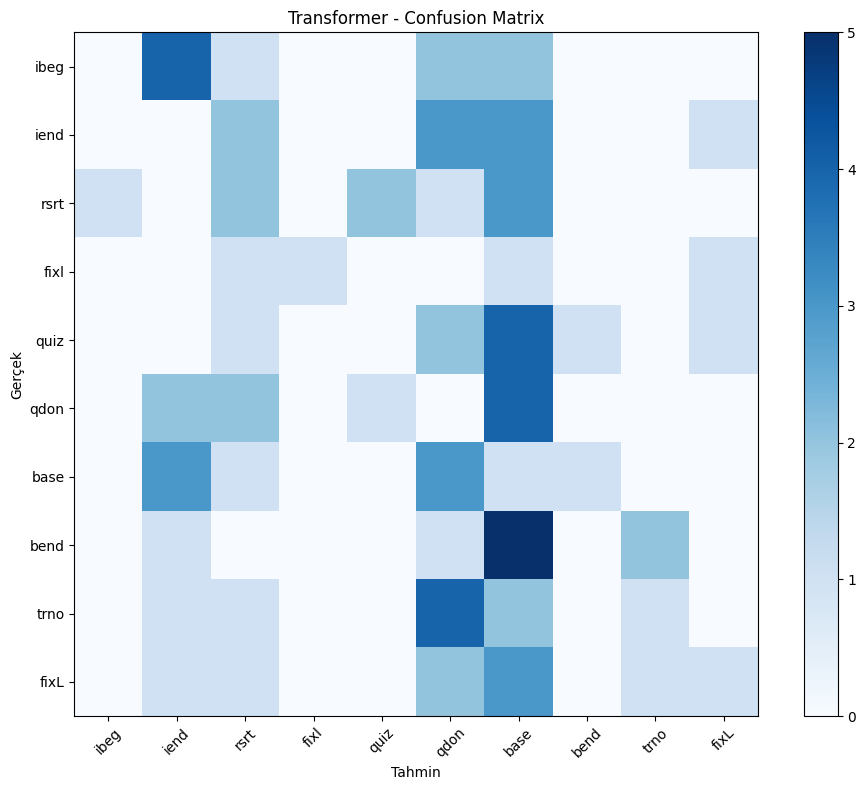

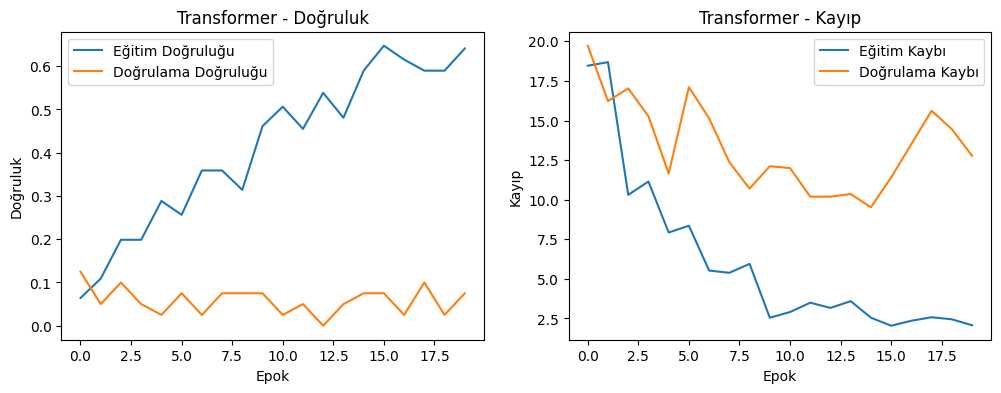


MODEL PERFORMANS KARŞILAŞTIRMASI:
RNN: Accuracy=0.0941, F1=0.0525, Kappa=-0.0132
LSTM: Accuracy=0.0588, F1=0.0210, Kappa=-0.0526
GRU: Accuracy=0.0471, F1=0.0234, Kappa=-0.0658
Transformer: Accuracy=0.0706, F1=0.0952, Kappa=-0.0387
Modeller ve ön işleme araçları başarıyla kaydedildi!


In [21]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
from tensorflow.keras.models import save_model
def main():
    DATA_DIR = "./EmotionData/Emotion_EDF_Training_Data"
    file_pairs = load_emotion_data(DATA_DIR)
    
    SEQ_LENGTH = 10                                                                                         # Zaman serisi uzunluğunu belirliyorum.
    
    X, y = create_emotion_dataset(file_pairs, epoch_duration=2.0, seq_length=SEQ_LENGTH)                    # Veri setini olusturuyorum.
    
    if len(X) == 0:
        print("Yeterli veri bulunamadı!")
        return
    
    print("X shape:", X.shape, "y shape:", y.shape)
    selector = SelectKBest(f_classif, k=2500)
    n_samples, seq_len, n_features = X.shape
    

    X_flat = X.reshape(-1, n_features)                                                                      # Veriyi 2 boyuta indiriyorum. (Boyut hatasi aliyordum bu flatten islemini ChatGPT onerdi.)
    imputer = SimpleImputer(strategy='mean', keep_empty_features=True)                                      # Nan degerleri sutun ortalamasiyla dolduracak imputer tanimliyorum.
    X_imputed_flat = imputer.fit_transform(X_flat)
    X_imputed = X_imputed_flat.reshape(n_samples, seq_len, n_features)                                      # Tekrar eski 3D sekline getiriyorum. (ornek, zaman, ozellik)
    

    X_collapsed = np.mean(X_imputed, axis=1)                                                                # Zaman boyutu boyunca ortalama alarak her örneği tek vektöre indiriyorum.                                                
    selector.fit(X_collapsed, y)
    selected_indices = selector.get_support(indices=True)
    
    X_selected = X_imputed[:, :, selected_indices]                                                          # Secilen özellikleri tutuyorum.
    print(f"Özellik seçimi sonrası boyut: {X_selected.shape}")

    n_features_selected = X_selected.shape[2]
    
    n_samples, seq_len, n_features_selected = X_selected.shape                                              # Veriyi olceklendiriyorum.
    X_flat_selected = X_selected.reshape(-1, n_features_selected)
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X_flat_selected)
    X_scaled = X_flat_scaled.reshape(n_samples, seq_len, n_features_selected)
    
    X_train, X_test, y_train, y_test = train_test_split(                                                    # Veriyi boluyorum.
        X_scaled, y, test_size=0.3, random_state=42, stratify=y
    )
    
    le = LabelEncoder()                                                                                     # Kullandigim labellari encode ediyorum.
    all_labels = np.concatenate([y_train, y_test])
    le.fit(all_labels)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    
    
    input_shape = (SEQ_LENGTH, n_features_selected)                                                         # Modelleri tanimliyorum ve egitiyorum.
    
    print("\RNN Model Eğitimi:")
    rnn_model = build_rnn_model(input_shape, rnn_type='SimpleRNN', units=128)
    _, rnn_metrics = train_and_evaluate(rnn_model, X_train, y_train, X_test, y_test, "SimpleRNN")

    print("\nLSTM Model Eğitimi:")
    lstm_model = build_rnn_model(input_shape, rnn_type='lstm', units=128)
    _, lstm_metrics = train_and_evaluate(lstm_model, X_train, y_train_enc, X_test, y_test_enc, "LSTM")
    
    print("\nGRU Model Eğitimi:")
    gru_model = build_rnn_model(input_shape, rnn_type='gru', units=128)
    _, gru_metrics = train_and_evaluate(gru_model, X_train, y_train_enc, X_test, y_test_enc, "GRU")
    
    print("\nTransformer Model Eğitimi:")
    transformer_model = build_transformer_model(input_shape)
    _, transformer_metrics = train_and_evaluate(transformer_model, X_train, y_train_enc, X_test, y_test_enc, "Transformer")
    

    print("\nMODEL PERFORMANS KARŞILAŞTIRMASI:")                                                             # Performanslarini karsilastiriyorum.
    print(f"RNN: Accuracy={rnn_metrics[0]:.4f}, F1={rnn_metrics[1]:.4f}, Kappa={rnn_metrics[2]:.4f}")
    print(f"LSTM: Accuracy={lstm_metrics[0]:.4f}, F1={lstm_metrics[1]:.4f}, Kappa={lstm_metrics[2]:.4f}")
    print(f"GRU: Accuracy={gru_metrics[0]:.4f}, F1={gru_metrics[1]:.4f}, Kappa={gru_metrics[2]:.4f}")
    print(f"Transformer: Accuracy={transformer_metrics[0]:.4f}, F1={transformer_metrics[1]:.4f}, Kappa={transformer_metrics[2]:.4f}")


    lstm_model.save('lstm_model.h5')                                                                          # Modelleri ve veri isleme araclarini kaydediyorum.
    rnn_model.save('rnn_model.h5') 
    gru_model.save('gru_model.h5')
    transformer_model.save('transformer_model.keras')
    joblib.dump(le, 'label_encoder.joblib')
    joblib.dump(scaler, 'scaler.joblib')
    joblib.dump(imputer, 'imputer.joblib')
    joblib.dump(selector, 'feature_selector.joblib')
    joblib.dump(selected_indices, 'selected_feature_indices.joblib')
    joblib.dump(n_features_selected, 'expected_features.joblib')
    print("Modeller ve ön işleme araçları başarıyla kaydedildi!")

if __name__ == "__main__":
    main()